[*********************100%***********************]  1 of 1 completed


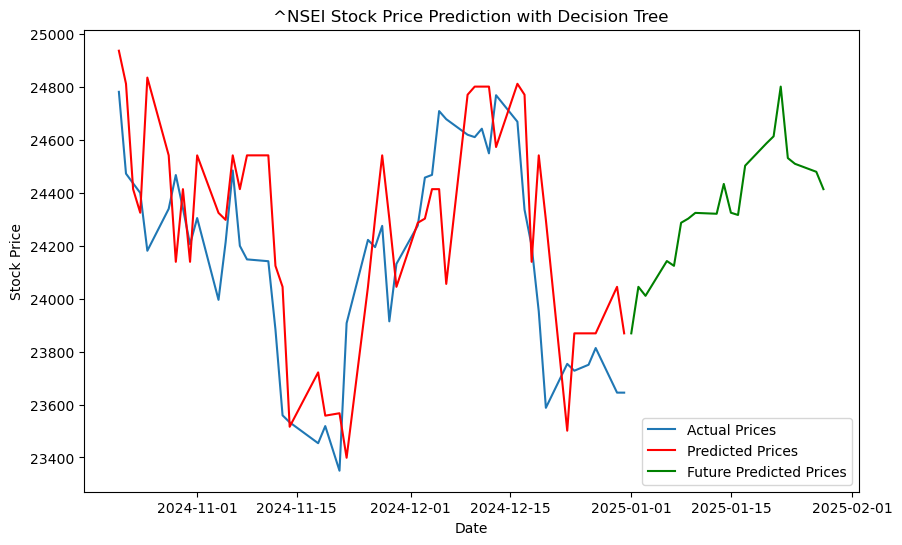

[*********************100%***********************]  1 of 1 completed

Mean Absolute Percentage Error (MAPE): 2.14%
Mean Absolute Error (MAE): 514.52
Root Mean Squared Error (RMSE): 577.11


In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 固定随机种子以确保结果可重现
seed_value = 42
np.random.seed(seed_value)

ticker = '^NSEI'
df = yf.download(ticker, start='2024-01-01', end='2025-01-01')

data = df['Close'].values
data = data.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

training_data_len = int(np.ceil(0.8 * len(scaled_data)))

train_data = scaled_data[:training_data_len, :]
test_data = scaled_data[training_data_len - 1:, :]  # 这里改为1，因为决策树不需要像LSTM那样的序列输入

# 准备决策树的特征和目标变量
x_train, y_train = [], []
for i in range(1, len(train_data)):
    x_train.append(train_data[i - 1, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train)

# 创建并训练决策树回归模型
model = DecisionTreeRegressor(random_state=42)
model.fit(x_train, y_train)

# 准备测试集的特征和目标变量
x_test, y_test = [], data[training_data_len:, :]
for i in range(1, len(test_data)):
    x_test.append(test_data[i - 1, 0])

x_test = np.array(x_test).reshape(-1, 1)

# 进行预测
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# 预测未来数据
future_steps = 20
last_data_point = test_data[-1, 0]  # 取测试集最后一个数据点作为起始
future_predictions = []
for _ in range(future_steps):
    input_data = np.array([[last_data_point]]).reshape(-1, 1)
    next_prediction = model.predict(input_data)[0]
    future_predictions.append(next_prediction)
    last_data_point = next_prediction

# 对未来预测值进行逆缩放
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 可视化
plt.figure(figsize=(10, 6))
plt.plot(df.index[training_data_len:], y_test, label='Actual Prices')
plt.plot(df.index[training_data_len:], predictions, label='Predicted Prices', color='red')

# 创建未来日期范围
future_dates = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='B')[1:]
plt.plot(future_dates, future_predictions, label='Future Predicted Prices', color='green')

plt.title(f'{ticker} Stock Price Prediction with Decision Tree')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 计算评估指标
raw_actual = yf.download(ticker, start='2024-12-01', end='2024-12-31')
raw_actual.dropna(inplace=True)
actual_values = np.array(raw_actual['Close'])

mape = np.mean(np.abs((actual_values - future_predictions) / actual_values)) * 100
mae = mean_absolute_error(actual_values, future_predictions)
rmse = np.sqrt(mean_squared_error(actual_values, future_predictions))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

In [43]:
df = pd.DataFrame(future_predictions)
df.to_csv('DTR_forecast.csv', index=False)